# **RDKit Workshop: Fingerprints, Descriptors, and Coding Limitations**
Coding: Supaporn Klabklaydee (Fujii laboratory)

This workshop is designed to give you hands-on experience with RDKit package a popular cheminformatics library in Python. You’ll learn how to generate different types of molecular fingerprints, calculate various molecular descriptors, and discuss limitations and common pitfalls in coding with RDKit.

[RDKIT_document](https://www.rdkit.org/docs/)

# **Environment Setup**
Installation Before starting, ensure RDKit is installed.

In [ ]:
!pip install rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, rdMolDescriptors, Draw
from rdkit.DataStructs import TanimotoSimilarity
print(Chem.__version__)

# **Fingerprint Generation Functions**

The idea of the code is that all supported fingerprinting algorithms can be used the same way. you create a generator for that fingerprint algorithm with the appropriate parameters set and then ask the generator to give you the fingerprint type you want for each molecule.
The fingerprint generator knows how to create four separate types of fingerprints:

fpgen.GetFingerprint(m): returns a bit vector of size fpSize
fpgen.GetCountFingerprint(m): returns a count vector of size fpSize
fpgen.GetSparseFingerprint(m): returns a sparse bit vector
fpgen.GetSparseCountFingerprint(m): returns a sparse count vector
The sparse bit and count vectors are of variable size, depending on the fingerprint type, but are always very large (at least
2^32-1).

---

As of this writing (RDKit v2022.09), the fingerprinting algorithms supported by the fingerprint generators are:


1.   Feature Morgan (this is a variation of the Morgan fingerprint)
2.  RDKit descriptors
3. Atom pairs
4. Topological torsions

In [ ]:
ibuprofen = Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O')
ibuprofen

**Morgan Fingerprints (Circular Fingerprints)**
This family of fingerprints, better known as circular fingerprints, is built by applying the Morgan algorithm to a set of user-supplied atom invariants. When generating Morgan fingerprints, the radius of the fingerprint can also be provided (the default is 3)


In [ ]:
from rdkit.Chem.AtomPairs import Pairs
from rdkit import DataStructs

In [ ]:
from rdkit.Chem import AllChem
fpgen = AllChem.GetMorganGenerator(radius=2)
m1 = Chem.MolFromSmiles('Cc1ccccc1')
fp1 = fpgen.GetSparseCountFingerprint(m1)
fp1
m2 = Chem.MolFromSmiles('Cc1ncccc1')
fp2 = fpgen.GetSparseCountFingerprint(m2)
DataStructs.DiceSimilarity(fp1,fp2)

In [ ]:
fp1 = fpgen.GetFingerprint(m1)
fp1
len(fp1)
fp2 = fpgen.GetFingerprint(m2)
DataStructs.DiceSimilarity(fp1,fp2)

The default atom invariants use connectivity information similar to those used for the well known ECFP family of fingerprints. Feature-based invariants, similar to those used for the FCFP fingerprints, can also be used by creating the fingerprint generator with an appropriate atom invariant generator.

In [ ]:
m1 = Chem.MolFromSmiles('c1ccccn1')
m2 = Chem.MolFromSmiles('c1ccco1')
fpgen = AllChem.GetMorganGenerator(radius=2)
fp1 = fpgen.GetSparseCountFingerprint(m1)
fp2 = fpgen.GetSparseCountFingerprint(m2)
invgen = AllChem.GetMorganFeatureAtomInvGen()
ffpgen = AllChem.GetMorganGenerator(radius=2, atomInvariantsGenerator=invgen)
ffp1 = ffpgen.GetSparseCountFingerprint(m1)
ffp2 = ffpgen.GetSparseCountFingerprint(m2)
DataStructs.DiceSimilarity(fp1,fp2)
DataStructs.DiceSimilarity(ffp1,ffp2)

When comparing the ECFP/FCFP fingerprints and the Morgan fingerprints generated by the RDKit, remember that the 4 in ECFP4 corresponds to the diameter of the atom environments considered, while the Morgan fingerprints take a radius parameter. So the examples above, with radius=2, are roughly equivalent to ECFP4 and FCFP4.

The user can also provide their own atom invariants using the optional customAtomInvariants argument to the GetFingerprint() call. Here’s a simple example that uses a constant for the invariant; the resulting fingerprints compare the topology of molecules:

In [ ]:
m1 = Chem.MolFromSmiles('Cc1ccccc1')
m2 = Chem.MolFromSmiles('Cc1ncncn1')
fpgen = AllChem.GetMorganGenerator(radius=2)
fp1 = fpgen.GetFingerprint(m1,customAtomInvariants=[1]*m1.GetNumAtoms())
fp2 = fpgen.GetFingerprint(m2,customAtomInvariants=[1]*m2.GetNumAtoms())
fp1==fp2

In [ ]:
m3 = Chem.MolFromSmiles('CC1CCCCC1')
fp3 = fpgen.GetFingerprint(m3,customAtomInvariants=[1]*m3.GetNumAtoms())
fp1==fp3

In [ ]:
fpgen = AllChem.GetMorganGenerator(radius=2,useBondTypes=False)
fp1 = fpgen.GetFingerprint(m1,customAtomInvariants=[1]*m1.GetNumAtoms())
fp3 = fpgen.GetFingerprint(m3,customAtomInvariants=[1]*m3.GetNumAtoms())
fp1==fp3

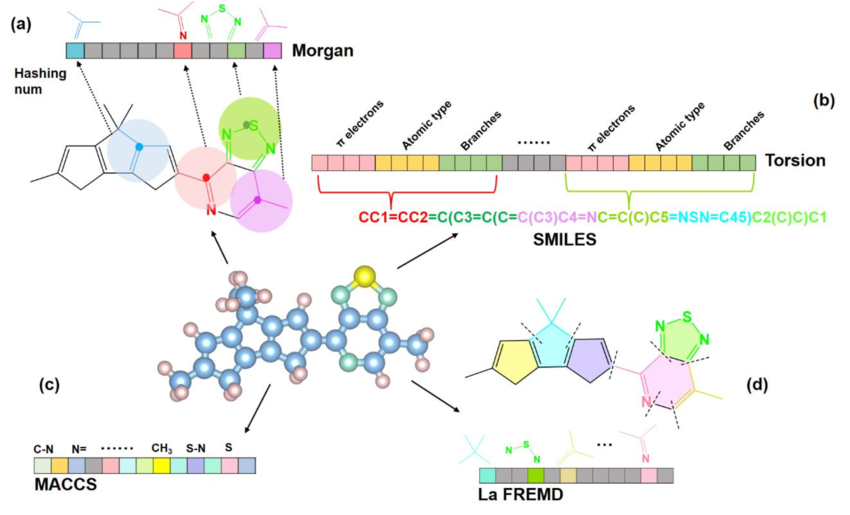

DOI: 10.21203/rs.3.rs-1813671/v1

MACCS Keys
There is a SMARTS-based implementation of the 166 public MACCS keys.

In [ ]:
from rdkit.Chem import MACCSkeys
ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'),
Chem.MolFromSmiles('COC')]
fps = [MACCSkeys.GenMACCSKeys(x) for x in ms]
DataStructs.TanimotoSimilarity(fps[0],fps[1])
DataStructs.TanimotoSimilarity(fps[0],fps[2]).
DataStructs.TanimotoSimilarity(fps[1],fps[2])

Explaining bits from fingerprints
The fingerprint generators can collect information about the atoms/bonds involved in setting bits when a fingerprint is generated. This information is quite useful for understanding which parts of a molecule were involved in each bit.

Each fingerprinting method provides different information, but this is all accessed using the additionalOutput argument to the fingerprinting functions.

Morgan Fingerprints
Information is available about the atoms that contribute to particular bits in the Morgan fingerprint via the bit info map. This is a dictionary with one entry per bit set in the fingerprint, the keys are the bit ids, the values are lists of (atom index, radius) tuples.

In [ ]:
m = Chem.MolFromSmiles('c1cccnc1C')
fpgen = AllChem.GetMorganGenerator(radius=2)
ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()
fp = fpgen.GetSparseCountFingerprint(m,additionalOutput=ao)
len(fp.GetNonzeroElements())
info = ao.GetBitInfoMap()
len(info)
info[98513984]
info[4048591891]

Interpreting the above: bit 98513984 is set twice: once by atom 1 and once by atom 2, each at radius 1. Bit 4048591891 is set once by atom 5 at radius 2.

Focusing on bit 4048591891, we can extract the submolecule consisting of all atoms within a radius of 2 of atom 5:

In [ ]:
env = Chem.FindAtomEnvironmentOfRadiusN(m,2,5)
amap={}
submol=Chem.PathToSubmol(m,env,atomMap=amap)
submol.GetNumAtoms()
amap

In [ ]:
mfp1gen = rdFingerprintGenerator.GetMorganGenerator(radius=1)

ao = rdFingerprintGenerator.AdditionalOutput()
# we have to ask for the information we're interested in by allocating space for it:
ao.AllocateAtomCounts()
ao.AllocateAtomToBits()
ao.AllocateBitInfoMap()

fp = mfp1gen.GetFingerprint(ibuprofen,additionalOutput=ao)

In [ ]:
ao.GetBitInfoMap()

In [ ]:
ao.GetAtomCounts()

In [ ]:
ao.GetAtomToBits()

In [ ]:
# disable count simulation because there was a bug with the additional output and count
ttgen = rdFingerprintGenerator.GetTopologicalTorsionGenerator(countSimulation=False)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitPaths()

fp = ttgen.GetFingerprint(ibuprofen,additionalOutput=ao)
ao.GetBitPaths()

In [ ]:
from rdkit import DataStructs
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
# for a direct comparison we need to use a fingerprint 4 times as long:
simfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096,countSimulation=True)
fps = [fpgen.GetFingerprint(m) for m in ms]
countfps = [fpgen.GetCountFingerprint(m) for m in ms]
simfps = [simfpgen.GetFingerprint(m) for m in ms]

countsims = []
sims = []
simsims = []
for i in range(len(ms)//2):
    for j in range(i+i,len(ms)//2):
        countsims.extend(DataStructs.BulkTanimotoSimilarity(countfps[i],countfps[j:]))
        sims.extend(DataStructs.BulkTanimotoSimilarity(fps[i],fps[j:]))
        simsims.extend(DataStructs.BulkTanimotoSimilarity(simfps[i],simfps[j:]))

In [ ]:
from scipy import stats

In [ ]:
bvr,_ = stats.spearmanr(countsims,sims)
simr,_ = stats.spearmanr(countsims,simsims)
print(bvr,simr)

In [ ]:
figsize(12,6)
subplot(1,2,1)
hexbin(countsims,sims,bins='log')
plot((0,1),(0,1),'k-')
title(f'bit vector similarity, r={bvr:.2f}')
xlabel('count similarity')
subplot(1,2,2)
hexbin(countsims,simsims,bins='log')
plot((0,1),(0,1),'k-')
title(f'simulated counts similarity, r={simr:.2f}')
xlabel('count similarity');

# **Molecular descriptors**

The molecular descriptor is the final result of a logic and mathematical procedure which transforms chemical information encoded within a symbolic representation of a molecule into a useful number or the result of some standardized experiment.
By this definition, the molecular descriptors are divided into two main categories: experimental measurements, such as log P, molar refractivity, dipole moment, polarizability, and, in general, additive physico-chemical properties, and theoretical molecular descriptors, which are derived from a symbolic representation of the molecule and can be further classified according to the different types of molecular representation


---

The main classes of theoretical molecular descriptors are:
1) **0D-descriptors** (i.e. constitutional descriptors, count descriptors)

1. **0D-descriptors** (i.e. constitutional descriptors, count descriptors)
2. **1D-descriptors** (i.e. list of structural fragments, fingerprints)
3. **2D-descriptors** (i.e. graph invariants)
4. **3D-descriptors** (such as, for example, 3D-MoRSE descriptors, WHIM descriptors, GETAWAY descriptors, quantum-chemical descriptors, size, steric, surface and volume descriptors)
5. **4D-descriptors** (such as those derived from GRID or CoMFA methods, Volsurf).

The outspread of artificial intelligence and machine learning to computational chemistry has also lead to various attempts to uncover new descriptors or to find the most predictive ones among some sort of candidates.

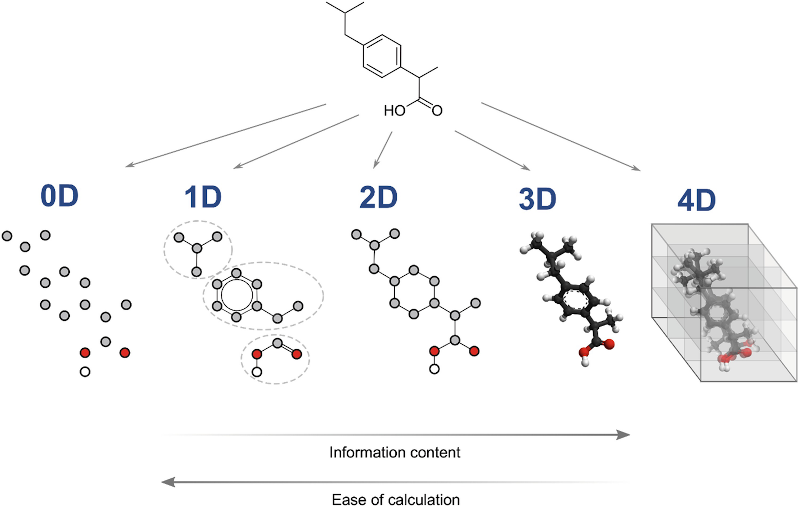

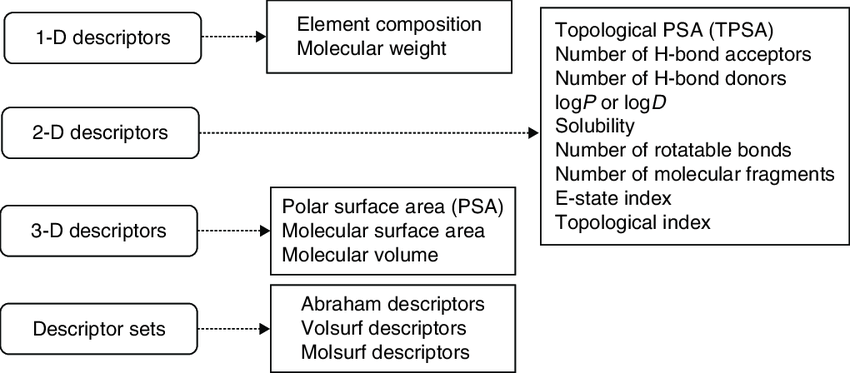

In [ ]:
# Function to calculate a set of molecular descriptors
def calculate_descriptors(mol):
    descriptors = {
        'Molecular Weight': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'H-Bond Donors': rdMolDescriptors.CalcNumHBD(mol),
        'H-Bond Acceptors': rdMolDescriptors.CalcNumHBA(mol)
    }
    return descriptors

In [ ]:
m = Chem.MolFromSmiles('c1cccnc1C')
descriptors = calculate_descriptors(m)
print(descriptors)

# **Substructure queries using SMARTS**

RDKit also can use to find matching 2D structures in organic molecules, using SMARTS queries. It uses RDKit's very nice structure renderer to show matches.

In [ ]:
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [ ]:
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
skatole = Chem.MolFromSmiles('CC1=CNC2=CC=CC=C12')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')

my_molecules = [naphthalene,
                benzoxazole,
                indane,
                skatole,
                benzene,
                quinoline,
               ]

In [ ]:
Draw.MolsToGridImage(my_molecules, useSVG=False)

In [ ]:
is_in_two_rings = Chem.MolFromSmarts('[R2]')
[mol.HasSubstructMatch(is_in_two_rings) for mol in my_molecules]

Defining substructure queries
SMARTS is a chemical structure query language. RDKit can import SMARTS queries for use in searching against sets of existing RDKit molecules.

**SMARTS query for any five-membered ring fused to a benzene ring**

In [ ]:
benzo_five = Chem.MolFromSmarts('[*r5R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r5R1][*r5R1]1')

**SMARTS query for any six-membered ring fused to a benzene ring**

In [ ]:
benzo_six = Chem.MolFromSmarts('[*r6R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r6R1][*r6R1][*r6R1]1')

In [ ]:
smarts_queries = [benzo_five, benzo_six]

Using SMARTS instead of SMILES to initialize molecules does not result in instantiation of a molecule's RingInfo property. Thus, until Chem.GetSSSR() is invoked on a SMARTS-derived molecule, certain queries will fail.

In [ ]:
try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print('Success!  Your query worked.')
except RuntimeError as err:
    print('ERROR; {0} because RingInfo wasn\'t initialized\n'.format(err))

# initialize rings
[Chem.GetSSSR(mol) for mol in smarts_queries]

try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print('Success!  Your query worked.\n')
except RuntimeError as err:
    print('ERROR; {0} because RingInfo wasn\'t initialized'.format(err))

Now that our query molecules' RingInfo is instantiated, it will be possible to compute meaningful 2D sets of coordinates for the SMARTS molecule and to both (a) query against the SMARTS molecule and (b) use the SMARTS molecule as a query against other molecules. Without calling Chem.GetSSSR(), only the second option would be viable.

In [ ]:
[AllChem.Compute2DCoords(mol) for mol in smarts_queries]

In [ ]:
# matching the first query
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_five, acceptFailure = True)

Our matching to our first query is done, and now all we have to do is draw the results.

**Showing the hits: five-membered rings fused to benzene**

The trick here is that the IPythonConsole module of rdkit.Chem.Draw doesn't seem to pass through the highlightSubstructs = True parameter to the appropriate rendering function, even though it does result in setting the mol.__sssAtoms property for each molecule. We can pass this parameter manually.

In [ ]:
highlight_lists = [mol.GetSubstructMatch(benzo_five) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules,
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )

The graph above shows that skatole, indane, and benzoxazole hit our first query, which tested whether a molecule contained a benzene fused to a five-membered ring. The skatole example illustrates that not all atoms in a molecule need to match a query, and also that only those atoms that match will be highlighted.

As expected, benzene isn't highlighted because it doesn't contain two rings, and naphthalene and quinoline aren't highlighted because they contain benzene fused to a six-membered ring.

**Showing the hits: six-membered rings fused to benzene**

The other query was to check for benzene fused to six-membered rings. This should hit naphthalene and quinoline.

In [ ]:
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_six, acceptFailure = True)

In [ ]:
# make sure the molecules are storing information about the SSS match:
highlight_lists = [mol.GetSubstructMatch(benzo_six) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules,
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )

# **Application of RDKIT**

In [ ]:
import pandas as pd
from rdkit.Chem import PandasTools

In [ ]:
df = pd.read_csv('../data/chembl_drugs.txt.gz', sep='\t')

In [ ]:
[str(x) for x in df.columns]

In [ ]:
len(df)

Keep only compounds with SMILES,that respect Ro5 and are on the market

In [ ]:
df = df[df['CANONICAL_SMILES'].notnull() & # Keep cpds with SMILES
        (df['RULE_OF_FIVE'] == 'Y') & # that respect Ro5
        (df['DEVELOPMENT_PHASE'] == 4)] # are on the market

In [ ]:
len(df)

Table contains CANONICAL_SMILES with SMILES which we can convert to RDKit molecules (default name ROMol)

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='CANONICAL_SMILES')

In [ ]:
df = df[~df['ROMol'].isnull()]

Extract a name from SYNONYMS column by applying a row-wise operation

In [ ]:
df['name'] = df.apply(lambda x: x['SYNONYMS'].split('(')[0] if type(x['SYNONYMS']) is str else None, axis=1)

Depict first 10 mols

In [ ]:
PandasTools.FrameToGridImage(df.head(10), legendsCol='name', molsPerRow=5)

Calculate some descriptors and visualize distributions

In [ ]:
df['MW'] = df['ROMol'].map(Descriptors.MolWt)
df['logP'] = df['ROMol'].map(Descriptors.MolLogP)

In [ ]:
df['MW'].hist();

In [ ]:
df['logP'].hist();

Do a substructure search on a dataframe

In [ ]:
query = Chem.MolFromSmarts('Nc1ccc(S(=O)(=O)-[*])cc1')
query

Notice that unspecified bonds in the SMARTS are "single or aromatic" queries. We could make this query a bit more specific:

In [ ]:
query = Chem.MolFromSmarts('N-c1ccc(-S(=O)(=O)-[*])cc1')
query

We do a substruture search by using the operator >= on a molecule column.

In [ ]:
len(df[df['ROMol'] >= query])

In [ ]:
df[df['ROMol'] >= query][['SYNONYMS', 'ROMol']].head()

In [ ]:
PandasTools.FrameToGridImage(df[df['ROMol'] >= query].head(20), legendsCol='name', molsPerRow=5)

# **Chemical space analysis of small molecule drugs with RDKit and dimensionality reduction methods**

In [ ]:
import numpy as np

In [ ]:
df = pd.read_csv('../data/chembl_drugs.txt.gz', sep='\t')

In [ ]:
df = df[df['CANONICAL_SMILES'].notnull() & # Keep cpds with SMILES
        df['USAN_STEM'].notnull() & # USAN stem
        (df['RULE_OF_FIVE'] == 'Y') & # that respect Ro5
        (df['DEVELOPMENT_PHASE'] == 4)] # are on the market

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='CANONICAL_SMILES')

In [ ]:
df = df[~df['ROMol'].isnull()]

Check most common compound classees (based on USAN stem)

In [ ]:
common_stems = df.groupby('USAN_STEM').size().sort_values()[-10:]
common_stems

In [ ]:
stems = df.drop_duplicates(['USAN_STEM'])[df.drop_duplicates(['USAN_STEM'])['USAN_STEM'].isin(common_stems.index)][['USAN_STEM','USAN_STEM_DEFINITION']]
stems.index = stems['USAN_STEM']
stems['count'] = common_stems

In [ ]:
stems

In [ ]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df

    Parameters
    ----------
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circular (Morgan) fingerprint.
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float
        Fingerprint radius, default 2
    nBits : int
        Length of hashed fingerprint (without descriptors), default 1024
    useFeatures : bool
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool
        If set to true it returns for each bit number of appearances of each substructure (counts). Defaults to false (fingerprint is binary)
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32 because it is the default dtype for scikit-learn

    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)

    if counts is True:
        info = {}
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
        DataStructs.ConvertToNumpyArray(fp, arr)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return FP(arr, range(nBits))

Calculate fingerprints

In [ ]:
df['FP'] = df['ROMol'].map(get_cfps)

Extract compounds that belong to 10 most common USAN stems

In [ ]:
df_small = df[df['USAN_STEM'].isin(list(stems.index))].copy()

In [ ]:
len(df_small)

**PCA analysis**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X = np.array([x.fp for x in df_small['FP']])

In [ ]:
pca = PCA(n_components=3, random_state=0)
pca_drugs = pca.fit_transform(X)

In [ ]:
df_small['PC1'] = pca_drugs.T[0]
df_small['PC2'] = pca_drugs.T[1]
df_small['PC3'] = pca_drugs.T[2]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.pairplot(df_small, hue='USAN_STEM', vars=['PC1', 'PC2', 'PC3'], palette='viridis');

**t-SNE**
Note that t-SNE is very sensitive to hyperparameter settings

**Without PCA preprocessing**

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_drugs = model.fit_transform(X)

In [ ]:
df_small['TSNE_C1'] = tsne_drugs.T[0]
df_small['TSNE_C2'] = tsne_drugs.T[1]

In [ ]:
sns.pairplot(df_small, hue='USAN_STEM', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis');

**With PCA preprocessing**

In case of high dimensionality data (like molecular fingerprints) it is recommended to reduce the number of dimensions with another method before proceeding with t-SNE.

In [ ]:
pca_model = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_pca_drugs = tsne_model.fit_transform(pca_model.fit_transform(X))

In [ ]:
df_small['TSNE_PCA_C1'] = tsne_pca_drugs.T[0]
df_small['TSNE_PCA_C2'] = tsne_pca_drugs.T[1]

In [ ]:
sns.pairplot(df_small, hue='USAN_STEM', vars=['TSNE_PCA_C1', 'TSNE_PCA_C2'], palette='viridis');

# **Comparison of molecular descriptors using RDkit and Mordred**

In [ ]:
!pip install mordred

In [ ]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd
import numpy as np
from mordred import Calculator, descriptors

In [ ]:
dataset = pd.read_csv("Orbital_Energies_input_data.csv")
dataset.shape

In [ ]:
dataset.head()

In [ ]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [ ]:
Canon_SMILES = canonical_smiles(dataset.SMILES)
len(Canon_SMILES)

In [ ]:
dataset['SMILES'] = Canon_SMILES
dataset

In [ ]:
duplicates_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
len(duplicates_smiles)

In [ ]:
dataset[dataset['SMILES'].isin(duplicates_smiles)].sort_values(by=['SMILES'])

In [ ]:
dataset_new = dataset.drop_duplicates(subset=['SMILES'])
len(dataset_new)

In [ ]:
dataset_new

**Calculate descriptors using RDkit**

1. General molecular descriptors-about 200 molecular descriptors
2. Fingerprint



In [ ]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(dataset_new['SMILES'])

In [ ]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

In [ ]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

In [ ]:
Morgan_fpts = morgan_fpts(dataset_new['SMILES'])
Morgan_fpts.shape

In [ ]:
Morgan_fingerprints = pd.DataFrame(Morgan_fpts,columns=['Col_{}'.format(i) for i in range(Morgan_fpts.shape[1])])
Morgan_fingerprints

**Calculate descriptors using Mordred-1826 descriptors**

In [ ]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]

    # pandas df
    df = calc.pandas(mols)
    return df

In [ ]:
mordred_descriptors = All_Mordred_descriptors(dataset_new['SMILES'])

In [ ]:
mordred_descriptors.shape

In [ ]:
mordred_descriptors

# **HOMO-LUMO Energy Gap Prediction using RDKit Molecular descriptors**

HOMO stands for highest occupied molecular orbital and LUMO stands for lowest unoccupied molecular orbital. HOMO-LUMO molecular orbitals are called frontier molecular orbitals. They are involved in chemical bond formation. Especially, pericyclic reactions such as cycloaddition, electrocyclic reactions, and sigmatropic rearrangement are explained using HOMO-LUMO molecular orbitals. In addition, in UV-Visible spectroscopy, the absorbance of organic molecules that have extended conjugated double bonds can be rationalized using the HOMO-LUMO energy gap of the molecules.

In [ ]:
!pip install lazypredict

In [ ]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
#----------------------------------------------------
import pandas as pd
import numpy as np
#----------------------------------------------------
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
#----------------------------------------------------
# https://lazypredict.readthedocs.io/en/latest/readme.html
# https://github.com/shankarpandala/lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
sn.displot(dataset_new.Energygap)

In [ ]:
dataset_new.Energygap.describe()

In [ ]:
np.median(dataset_new.Energygap)

In [ ]:
sn.boxplot(dataset_new.Energygap)

Remove highly correlated features

In [ ]:
def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(np.bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped

In [ ]:
descriptors_new = remove_correlated_features(df_with_200_descriptors)
descriptors_new

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(descriptors_new, threshold=0.1)
X

In [ ]:
# Assign Features and Labels
X  # molecular features
y = dataset_new.Energygap # labels or targets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, prediction_tests = lregs.fit(X_train, X_test, y_train, y_test)

In [ ]:
prediction_tests

 Use the top two models and do parameters tuning

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
gbr = HistGradientBoostingRegressor()

Use the optimized parameters to predict test sets

In [ ]:
lgbm_opt =LGBMRegressor(max_depth=5,min_samples_split=4, n_estimators= 800,max_features='auto')

In [ ]:
gbr_opt = HistGradientBoostingRegressor(learning_rate= 0.22)#learning_rate= 0.22

In [ ]:
# Train the model and predict the energy gap using X_test
lgbm_opt.fit(X_train, y_train)
lgbm_predict = lgbm_opt.predict(X_test)

# Train the model and predict the energy gap using X_test
gbr_opt.fit(X_train, y_train)
gbr_predict = gbr_opt.predict(X_test)

In [ ]:
# Take the average of the optimized predictions
ave_predict = (lgbm_predict + gbr_predict)/2

In [ ]:
# Model performance using MAE
MAE = mean_absolute_error(y_test, ave_predict)
print('MAE:', MAE)

In [ ]:
df_ = pd.DataFrame()

In [ ]:
df_['Actual'] = np.array(y_test)
df_['Predicted'] = ave_predict

In [ ]:
df_[:50]

In [ ]:
# R^2 (coefficient of determination) regression score function:
R2 =r2_score(y_test, ave_predict)
print('R^2:', R2)

In [ ]:
sn.regplot(x=ave_predict , y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Test set", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
MAE = mpatches.Patch(label="MAE={:04.2f}".format(MAE))
plt.legend(handles=[R2, MAE])

Save your model for future use

In [ ]:
import pickle
with open('lgbm_model.pkl','wb') as f:
          pickle.dump(lgbm_opt,f)

with open('hgbr_model.pkl','wb') as f:
          pickle.dump(gbr_opt,f)
with open('scaler.pkl','wb') as f:
          pickle.dump(scaler,f)

Load your model

In [ ]:
# with open('lgbm_model.pkl','rb') as f:
#     model_lgbm = pickle.load(f)

# with open('hgbr_model.pkl','rb') as f:
#     model_hgbr = pickle.load(f)